In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import igl
import numpy as np
import scipy as sp
from meshplot import plot, subplot, interact
from scipy.sparse.linalg import spsolve
import meshplot
import os
import math
import meshzoo
import skimage
from skimage import measure

In [2]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import sys

In [3]:
def normalVector(phi, theta):
    x = math.sin(phi) * math.cos(theta)
    y = math.sin(phi) * math.sin(theta)
    z = math.cos(phi)
    norm = [x,y,z]
    return norm

def dotProduct(vec1, vec2):
    a = 0
    for i in range(len(vec1)):
        a += vec1[i]*vec2[i]
    return a

def angle(norm, vector, givAng):
    a = dotProduct(norm,vector)
    len1 = math.sqrt(dotProduct(norm, norm))
    len2 = math.sqrt(dotProduct(vector, vector))
    b = a/(len1*len2)
    if b>1:
        b = 1
    elif b<-1:
        b = -1
    else:
        ang = math.acos(b)
    return ang<=givAng


norm1 = normalVector(math.pi/2, 2*math.pi/3)
norm2 = normalVector(math.pi/2, 4*math.pi/3)
norm3 = normalVector(math.pi/2, 6*math.pi/3)



In [4]:
def remove(points, cells, f1_id, f2_id, f3_id):
    newcells = []
    newpoints = []
    temp = {}
    skip = False
    for i in range(len(points)):
        if i not in f3_id:
            newpoints.append(points[i])
            temp[i] = len(newpoints)-1

    for i in cells:
        for j in i:
            if j in f3_id:
                skip = True
        if not skip:
            newcells.append(i)
        skip = False
    for i in range(len(newcells)):
        for j in range(len(newcells[i])):
            newcells[i][j]=temp[newcells[i][j]]
    for i in range(len(f1_id)):
        f1_id[i]=temp[f1_id[i]]
    for i in range(len(f2_id)):
        f2_id[i]=temp[f2_id[i]]
    return np.asarray(newpoints),np.asarray(newcells), np.asarray(f1_id), np.asarray(f2_id)

In [5]:
def boundaryPoints(theta, phi, angle, numberOfPoints):
    invYawMatrix = np.array([[math.cos(phi),-math.sin(phi),0],[math.sin(phi),math.cos(phi),0],[0,0,1]])
    invPitchMatrix = np.array([[math.cos(theta),0,math.sin(theta)],[0,1,0],[-math.sin(theta),0,math.cos(theta)]])
    invTotalMatrix =invYawMatrix @ invPitchMatrix
    radius = math.sin(angle)
    dis = radius*2/numberOfPoints
    x = []
    y = []
    z = []
    for i in range(numberOfPoints+1):
        x.append(-radius+i*dis)
        x.append(-radius+i*dis)
        y.append(math.sqrt(radius**2-x[i*2]**2))
        y.append(-math.sqrt(radius**2-x[i*2]**2))
        z.append(math.sqrt(1-x[i*2]**2-y[i*2]**2))
        z.append(math.sqrt(1-x[i*2]**2-y[i*2]**2))
    coord = []
    for i in range(len(x)):
        temp = np.array([x[i],y[i],z[i]])
        coord.append(invTotalMatrix @ temp)
    return np.asarray(coord)

    
def moving(points, f3_id, theta, phi, angle, numberOfPoints):
    dis = sys.maxsize
    boundary = boundaryPoints(theta,phi,angle,numberOfPoints)
    for i in f3_id:
        #print(i)
        for j in range(len(boundary)):
            #print("here:",j)
            temp = math.sqrt((points[i][0]-boundary[j][0])**2 + (points[i][1]-boundary[j][1])**2 + (points[i][2]-boundary[j][2])**2)
            #print(temp)
            if dis>temp:
                #print("enter if")
                dis = temp
                tempidx = j
        points[i][0] = boundary[tempidx][0]
        points[i][1] = boundary[tempidx][1]
        points[i][2] = boundary[tempidx][2]
        dis = sys.maxsize
            

In [6]:
def shapeGen(R, A):
    points, cells = meshzoo.uv_sphere(num_points_per_circle=100, num_circles=60, radius=R)

    v = points
    r = math.pi/50
    f1_id = []
    f2_id = []
    f3_id = []
    f4_id = []
    f5_id = []
    ftotal_id = []

    color = []


    for i in range(len(v)):
        if angle(norm1, v[i], A):
            color += ['green']
            f3_id += [i]
            ftotal_id += [i]
        elif angle(norm2, v[i], A):
            color += ['green']
            f4_id += [i]
            ftotal_id += [i]
        elif angle(norm3, v[i], A):
            color += ['green']
            f5_id += [i]
            ftotal_id += [i]
        elif angle(norm2, v[i], A+r) or angle(norm3, v[i], A+r):
            color += ['red']
            f1_id += [i]
        else:
            if angle(norm1, v[i], A+r):
                color += ['blue']
                f2_id += [i]
            else:
                color += ['black']
    
    moving(points, f4_id, math.pi/2, 4*math.pi/3, A, 100)
    v=points
    return [v,f1_id,f2_id,points,cells,color]


C:\Users\72882\AppData\Local\Temp\ipykernel_9908\3477723534.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


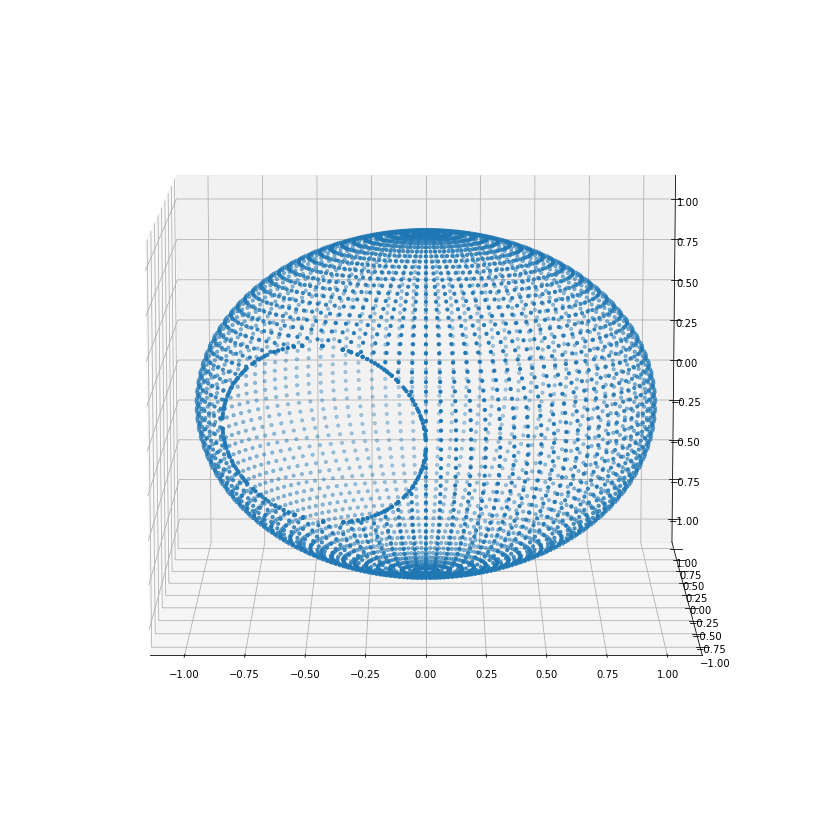

In [7]:
def show(R,A):
    v, f1_id, f2_id, points, cells, color = shapeGen(R,A)
    color = []
    r = math.pi/50
    #p = subplot(points, cells, shading={"wireframe": False}, s=[1,4,0])
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s = 10 , cmap='hsv')

    ax.view_init(10,-90)
    plt.show()
show(1,math.pi/6)

In [71]:
def miniQ(l,v,f1,f2):
    lt = np.transpose(l)
    boundV = []
    boundLt = []
    nonBoundLt = []
    nonBoundL2 = []
    for i in range(v.shape[0]):
        if i in f1 or i in f2:
            boundV.append(v[i])
            boundLt.append(lt[i])
        else:
            nonBoundLt.append(lt[i])

    boundL = np.transpose(boundLt)
    nonBoundL = np.transpose(nonBoundLt)

    for i in range(v.shape[0]):
        if i not in f1 and i not in f2:
            nonBoundL2.append(nonBoundL[i])
    b = -boundL.dot(boundV)
    b2 = []
    for i in range(v.shape[0]):
        if i not in f1 and i not in f2:
            b2.append(b[i])
    x = spsolve(nonBoundL2, b2)
    final = []
    temp = 0
    for i in range(v.shape[0]):
        if i in f1 or i in f2:
            final.append(v[i])
        else:
            final.append(x[temp])
            temp+=1
    return np.asarray(final)

In [72]:
def minimization(R,A):
    v = shapeGen(R,A)[0]
    cells = shapeGen(R,A)[4]
    f1_id = shapeGen(R,A)[1]
    f2_id = shapeGen(R,A)[2]

    vs = [v]
    es = []

    l = -1/8*igl.cotmatrix(vs[0],cells)
    vt = np.transpose(vs[0])
    es.append(vt.dot(l.dot(vs[0])).trace())

    for i in range(100):
        l = -1/8*igl.cotmatrix(vs[i],cells).toarray()

        Q = miniQ(l,vs[i],f1_id,f2_id)
        vs.append(Q)

        # energy 
        vt = np.transpose(vs[i+1])
        if(math.isnan(vt.dot(l.dot(vs[i+1])).trace())): break
        es.append(vt.dot(l.dot(vs[i+1])).trace())
    es=[ i for i in es if not(math.isnan(i)==True)]
    return [vs, cells, es]

In [73]:
#for testing
points, cells = meshzoo.uv_sphere(num_points_per_circle=100, num_circles=60, radius=R)

v = points
r = math.pi/50
f1_id = []
f2_id = []

color = []


for i in range(len(v)):
    if angle(norm1, v[i], A) or angle(norm3, v[i], A) or angle(norm2, v[i], A) or angle(norm4, v[i], A):
        color += ['red']
        f1_id += [i]
    else:
        if angle(norm1, v[i], A+r) or angle(norm3, v[i], A+r) or angle(norm2, v[i], A+r) or angle(norm4, v[i], A+r):
            color += ['blue']
            f2_id += [i]
        else:
            color += ['black']

points, cells, f1_id, f2_id = remove(points, cells, f1_id, f2_id, f3_id)
p = subplot(points, cells, shading={"wireframe": False}, s=[1,4,0])
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], s = 10 , c=color, cmap='hsv') #, cmap='hsv' )

ax.view_init(10,-90)

NameError: name 'A' is not defined

In [82]:
def area1(angle):
    return 4*math.pi * (math.sin(angle))**2



z = [5.2/math.pi,5.1/math.pi,5/math.pi,4.9/math.pi,4.8/math.pi,4.7/math.pi,4.6/math.pi,4.5/math.pi,4.4/math.pi,4.3/math.pi]
x = [1/i for i in z]
z = [1/math.sin(1/i) for i in z]

convV = []
convC = []
R = 1
for i in x:
    vs,cells,es = minimization(R,i)
    es=[ i for i in es if not(math.isnan(i)==True)]
    lastidx = len(es)-1
    convV.append(vs[lastidx])
    convC.append(cells)



c:\Users\72882\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
c:\Users\72882\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


In [83]:
convA = []
for i in range(len(convV)):
    area = skimage.measure.mesh_surface_area(convV[i],convC[i])
    convA.append(area)

convA

[3.3633952969874454,
 3.397532036198078,
 3.50130168415457,
 3.5971205099895527,
 3.9769309782893663,
 5.835367010645659,
 5.808922588455964,
 5.716437424781614,
 5.593147915021269,
 5.546669345426109]

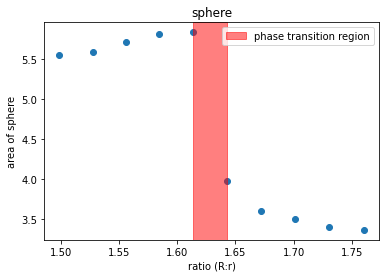

In [86]:
fig, ax = plt.subplots()
ax.scatter(z,convA)
ax.axvspan(z[4], z[5], alpha=0.5, color='red', label = "phase transition region")
ax.set_title("sphere")

plt.axis('on')
plt.ylabel("area of sphere")
plt.xlabel("ratio (R:r)")
plt.legend()
plt.savefig('3-circles')


In [88]:
success = igl.write_obj('3-circles-sphere-s',convV[4],convC[4])
print(success)


True


In [66]:
v,_,t,f,_,_= igl.read_obj('4-circles/4-circles-sphere-s')
p = subplot(v, f, shading={"wireframe": False}, s=[1,4,0])

In [85]:
p = subplot(convV[0], convC[0], shading={"wireframe": False}, s=[1,4,0])
p = subplot(convV[1], convC[1], shading={"wireframe": False}, s=[1,4,1],data=p)
p = subplot(convV[2], convC[2], shading={"wireframe": False}, s=[1,4,2],data=p)
p = subplot(convV[3], convC[3], shading={"wireframe": False}, s=[1,4,3],data=p)
p = subplot(convV[6], convC[6], shading={"wireframe": False}, s=[2,4,1],data=p)




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


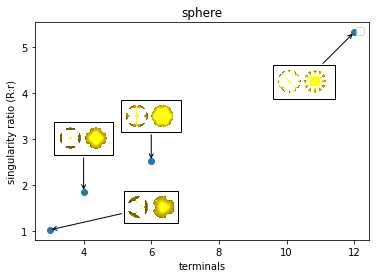

In [66]:
x=[3,4,6,12]
y=[1.02,1.85,2.52,5.32]

fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_title("sphere")

plt.axis('on')
plt.ylabel("singularity ratio (R:r)")
plt.xlabel("terminals")
plt.legend()

three = Image.open("3-terminals.png").convert("RGBA")
imagebox_three = OffsetImage(three, zoom=0.05)
ab_three = AnnotationBbox(imagebox_three, [x[0],y[0]], xybox=(6,y[0]+0.5),xycoords="data",arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab_three)

four = Image.open("4t.png").convert("RGBA")
imagebox_four = OffsetImage(four, zoom=0.05)
ab_four = AnnotationBbox(imagebox_four, [x[1],y[1]], xybox=[x[1],3], arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab_four)

six = Image.open("6t.png").convert("RGBA")
imagebox_six = OffsetImage(six, zoom=0.05)
ab_six = AnnotationBbox(imagebox_six, [x[2],y[2]], xybox=[x[2],3.5], arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab_six)

onetwo = Image.open("12.png").convert("RGBA")
imagebox_onetwo = OffsetImage(onetwo, zoom=0.05)
ab_onetwo = AnnotationBbox(imagebox_onetwo, [x[3],y[3]], xybox=[-50,-50], boxcoords="offset points",arrowprops=dict(arrowstyle="->"))
ax.add_artist(ab_onetwo)


plt.savefig('1test')

C:\Users\72882\AppData\Local\Temp\ipykernel_19772\4264813198.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


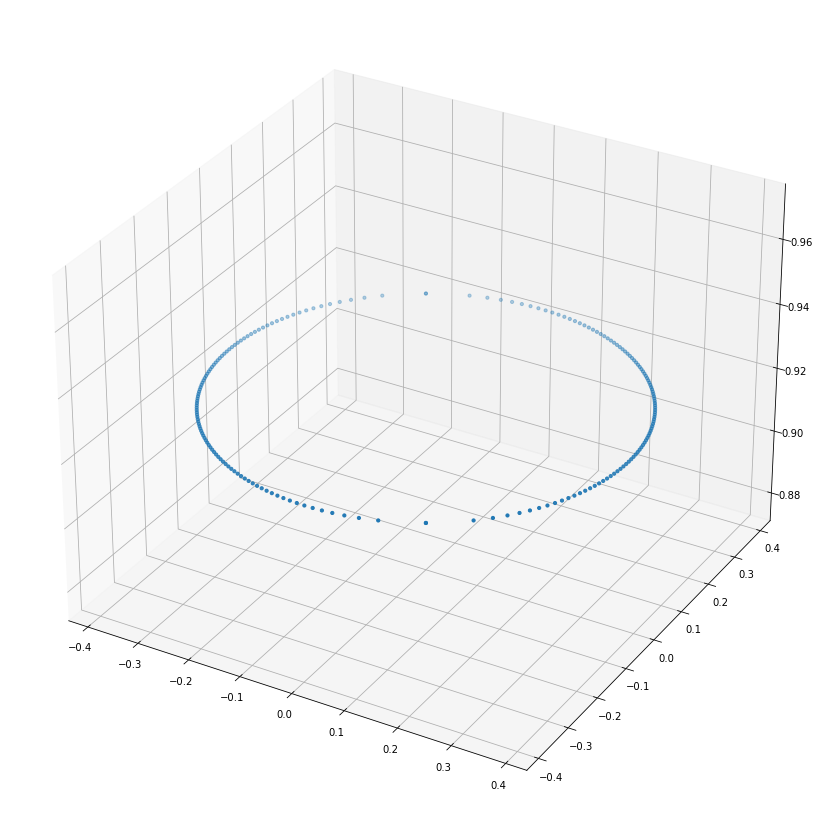

In [35]:
phi = math.pi/3
theta = 0
coord = boundaryPoints(theta, phi, math.pi/8, 100)
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.scatter3D(coord[:, 0], coord[:, 1], coord[:, 2], s = 10 , cmap='hsv')
